In [19]:
import pandas as pd
df = pd.read_csv('C:\\Users\\17376\\Desktop\\CYX\\study\\5261 Finance\\61project\\data\\weekly_master_edited.csv')
df_cleaned = df.iloc[:-2, :]
df_cleaned = df_cleaned.iloc[:, :9]
df_cleaned['date'] = pd.to_datetime(df_cleaned['date'])
df_new = df_cleaned[df_cleaned['date'] >= pd.to_datetime('2000-12-02')].copy()
df_new = df_new[:-1].copy()
print(df_new.tail())

           date  boeing       DJI      dollar        oil        GDP       CPI  \
1306 2025-01-11  171.09  43487.83  109.349998  72.259014  27967.697  0.190752   
1307 2025-01-18  176.06  44424.25  107.440002  72.019843  27967.697  0.190752   
1308 2025-01-25  176.52  44544.66  108.370003  71.780671  27967.697  0.190752   
1309 2025-02-01  181.49  44303.40  108.040001  71.541500  27967.697  0.190752   
1310 2025-02-08  180.55  44546.08  106.570000  71.541500  27967.697  0.190752   

      delivery           Al  
1306      44.0  2582.188571  
1307      44.0  2582.188571  
1308      44.0  2582.188571  
1309      44.0  2582.188571  
1310      44.0  2582.188571  


In [21]:
#pip install pmdarima

C:\Users\17376\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  self._init_dates(dates, freq)
C:\Users\17376\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  self._init_dates(dates, freq)
C:\Users\17376\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\17376\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  self._init_dates(dates, freq)
C:\Users\17376\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency i

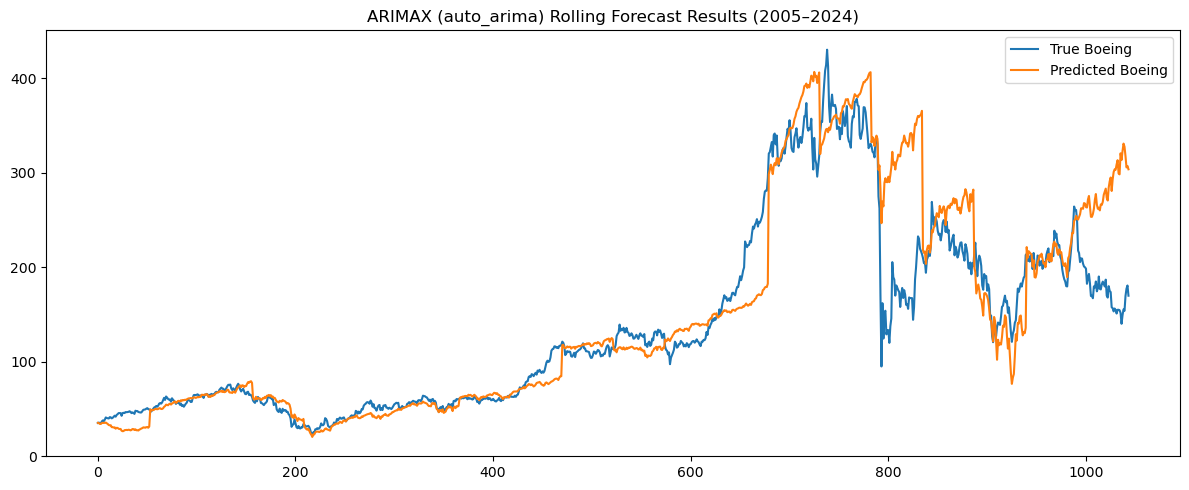

    year      order         MAE        RMSE       MAPE         R2
0   2005  (0, 1, 0)   13.758626   15.271229  29.957594 -11.565610
1   2006  (2, 1, 2)    3.531812    4.249266   6.099628   0.133961
2   2007  (0, 1, 0)    3.924389    5.478837   5.740371  -1.058434
3   2008  (0, 1, 0)    6.445120    7.266061  15.214413   0.566913
4   2009  (0, 1, 0)    3.185126    4.009510   9.308742   0.447956
5   2010  (0, 1, 0)    7.513859    8.343066  14.235456  -5.803122
6   2011  (0, 1, 0)    3.804618    4.275741   6.572474  -0.055766
7   2012  (1, 1, 0)    2.894127    3.580362   4.835399  -3.172097
8   2013  (1, 1, 0)   14.570100   18.601837  14.672501  -0.130676
9   2014  (2, 1, 0)    7.816793    8.580675   7.135198  -3.383189
10  2015  (0, 1, 0)   14.485315   15.070922  11.271274  -5.771660
11  2016  (1, 1, 0)   14.393611   15.290675  12.170233  -0.988199
12  2017  (1, 1, 0)   45.931642   56.661565  19.898397  -0.825951
13  2018  (3, 1, 2)   32.615241   42.793671   9.961339  -6.108075
14  2019  

In [13]:
import pandas as pd
import numpy as np
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# 你的 df_new 应该已经准备好了
df_new['date'] = pd.to_datetime(df_new['date'])
df_new.set_index('date', inplace=True)

results = []
predicted_all = []
true_all = []

for year in range(2005, 2025):
    train_data = df_new[df_new.index < f'{year}-01-01']
    test_data = df_new[(df_new.index >= f'{year}-01-01') & (df_new.index < f'{year+1}-01-01')]

    if len(test_data) == 0 or len(train_data) < 52:
        continue

    exog_vars = ['DJI', 'dollar', 'oil', 'GDP', 'CPI', 'delivery', 'Al']
    y_train = train_data['boeing']
    X_train = train_data[exog_vars]
    X_test = test_data[exog_vars]

    try:
        auto_model = auto_arima(
            y_train, exogenous=X_train,
            seasonal=False, stepwise=True, suppress_warnings=True,
            max_p=3, max_q=3, d=1, error_action='ignore'
        )

        model = SARIMAX(y_train, exog=X_train, order=auto_model.order,
                        enforce_stationarity=False, enforce_invertibility=False)
        model_fit = model.fit(disp=False)
        pred = model_fit.forecast(steps=len(X_test), exog=X_test)

        y_true = test_data['boeing']
        mae = mean_absolute_error(y_true, pred)
        rmse = mean_squared_error(y_true, pred, squared=False)
        mape = np.mean(np.abs((y_true - pred) / y_true)) * 100
        r2 = r2_score(y_true, pred)

        results.append({'year': year, 'order': auto_model.order,
                        'MAE': mae, 'RMSE': rmse, 'MAPE': mape, 'R2': r2})
        predicted_all.extend(pred)
        true_all.extend(y_true)
        date_all.extend(y_true.index)  # 存储预测期的日期

    except Exception as e:
        results.append({'year': year, 'order': None, 'MAE': None, 'RMSE': None,
                        'MAPE': None, 'R2': None, 'Error': str(e)})

result_df = pd.DataFrame(results)

plt.figure(figsize=(12, 5))
plt.plot(true_all, label='True Boeing')
plt.plot(predicted_all, label='Predicted Boeing')
plt.title('ARIMAX (auto_arima) Rolling Forecast Results (2005–2024)')
plt.legend()
plt.tight_layout()
plt.show()

print(result_df)


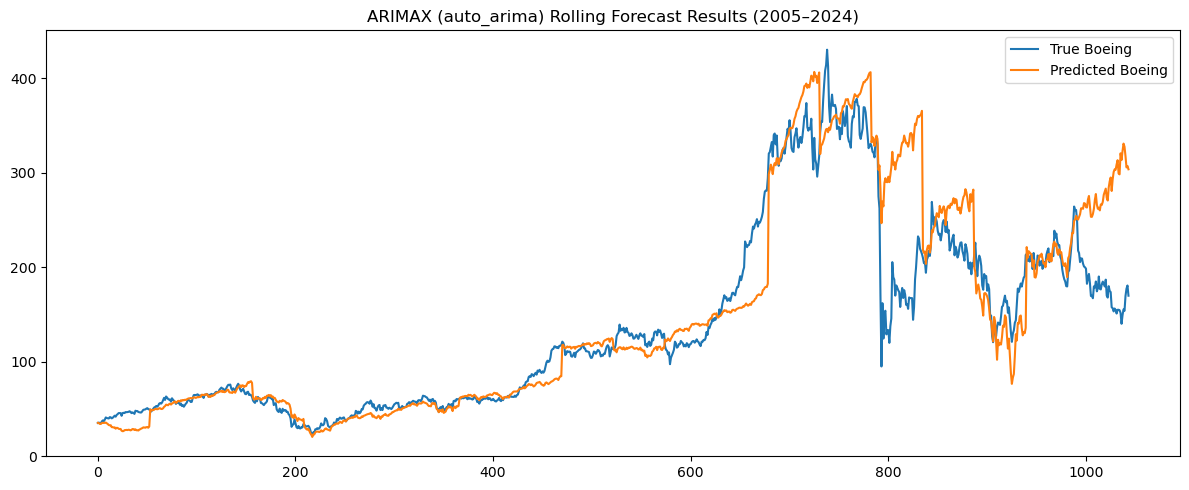

In [27]:
plt.figure(figsize=(12, 5))
plt.plot(true_all, label='True Boeing')
plt.plot(predicted_all, label='Predicted Boeing')
plt.title('ARIMAX (auto_arima) Rolling Forecast Results (2005–2024)')
plt.legend()
plt.tight_layout()
plt.savefig('boeing_forecast.png', dpi=300)
plt.show() 


In [29]:
print(result_df)

    year      order         MAE        RMSE       MAPE         R2
0   2005  (0, 1, 0)   13.758626   15.271229  29.957594 -11.565610
1   2006  (2, 1, 2)    3.531812    4.249266   6.099628   0.133961
2   2007  (0, 1, 0)    3.924389    5.478837   5.740371  -1.058434
3   2008  (0, 1, 0)    6.445120    7.266061  15.214413   0.566913
4   2009  (0, 1, 0)    3.185126    4.009510   9.308742   0.447956
5   2010  (0, 1, 0)    7.513859    8.343066  14.235456  -5.803122
6   2011  (0, 1, 0)    3.804618    4.275741   6.572474  -0.055766
7   2012  (1, 1, 0)    2.894127    3.580362   4.835399  -3.172097
8   2013  (1, 1, 0)   14.570100   18.601837  14.672501  -0.130676
9   2014  (2, 1, 0)    7.816793    8.580675   7.135198  -3.383189
10  2015  (0, 1, 0)   14.485315   15.070922  11.271274  -5.771660
11  2016  (1, 1, 0)   14.393611   15.290675  12.170233  -0.988199
12  2017  (1, 1, 0)   45.931642   56.661565  19.898397  -0.825951
13  2018  (3, 1, 2)   32.615241   42.793671   9.961339  -6.108075
14  2019  

In [37]:
len(df_new['date'])

1263

C:\Users\17376\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  self._init_dates(dates, freq)
C:\Users\17376\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  self._init_dates(dates, freq)
C:\Users\17376\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\17376\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  self._init_dates(dates, freq)
C:\Users\17376\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency i

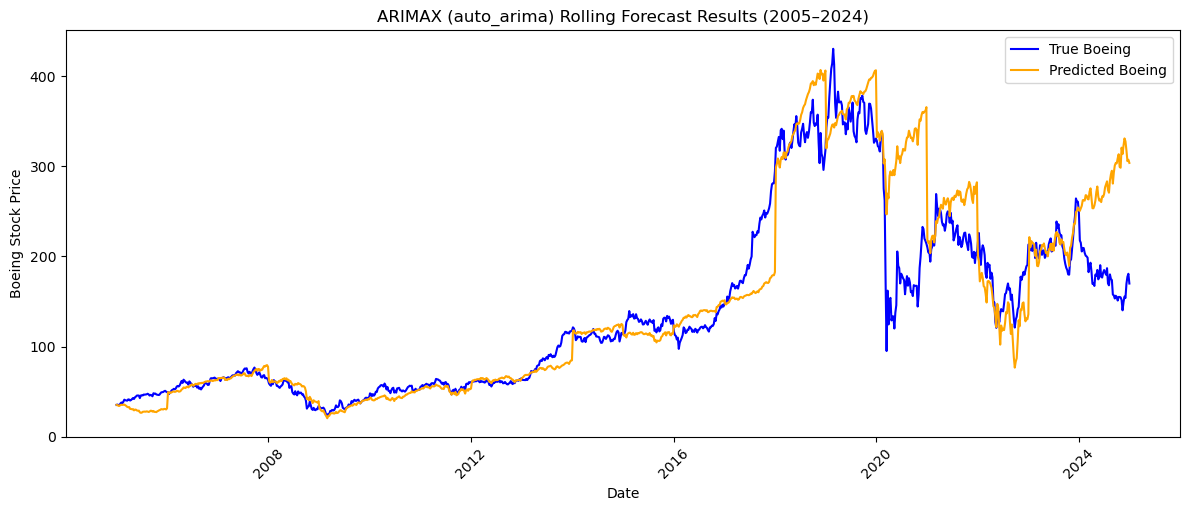

In [39]:
import pandas as pd
import numpy as np
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# 准备数据
df_new['date'] = pd.to_datetime(df_new['date'])
df_new.set_index('date', inplace=True)

# 初始化变量
results = []
predicted_all = []
true_all = []
date_all = []   

# 滚动建模
for year in range(2005, 2025):
    train_data = df_new[df_new.index < f'{year}-01-01']
    test_data = df_new[(df_new.index >= f'{year}-01-01') & (df_new.index < f'{year+1}-01-01')]

    if len(test_data) == 0 or len(train_data) < 52:
        continue

    exog_vars = ['DJI', 'dollar', 'oil', 'GDP', 'CPI', 'delivery', 'Al']
    y_train = train_data['boeing']
    X_train = train_data[exog_vars]
    X_test = test_data[exog_vars]

    try:
        auto_model = auto_arima(
            y_train, exogenous=X_train,
            seasonal=False, stepwise=True, suppress_warnings=True,
            max_p=3, max_q=3, d=1, error_action='ignore'
        )

        model = SARIMAX(y_train, exog=X_train, order=auto_model.order,
                        enforce_stationarity=False, enforce_invertibility=False)
        model_fit = model.fit(disp=False)
        pred = model_fit.forecast(steps=len(X_test), exog=X_test)

        y_true = test_data['boeing']
        mae = mean_absolute_error(y_true, pred)
        rmse = mean_squared_error(y_true, pred, squared=False)
        mape = np.mean(np.abs((y_true - pred) / y_true)) * 100
        r2 = r2_score(y_true, pred)

        results.append({'year': year, 'order': auto_model.order,
                        'MAE': mae, 'RMSE': rmse, 'MAPE': mape, 'R2': r2})
        predicted_all.extend(pred)
        true_all.extend(y_true)
        date_all.extend(y_true.index)  

    except Exception as e:
        results.append({'year': year, 'order': None, 'MAE': None, 'RMSE': None,
                        'MAPE': None, 'R2': None, 'Error': str(e)})

result_df = pd.DataFrame(results)

plt.figure(figsize=(12, 5))
plt.plot(date_all, true_all, label='True Boeing', color='blue')
plt.plot(date_all, predicted_all, label='Predicted Boeing', color='orange')
plt.title('ARIMAX (auto_arima) Rolling Forecast Results (2005–2024)')
plt.xlabel('Date')
plt.ylabel('Boeing Stock Price')
plt.legend()
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()



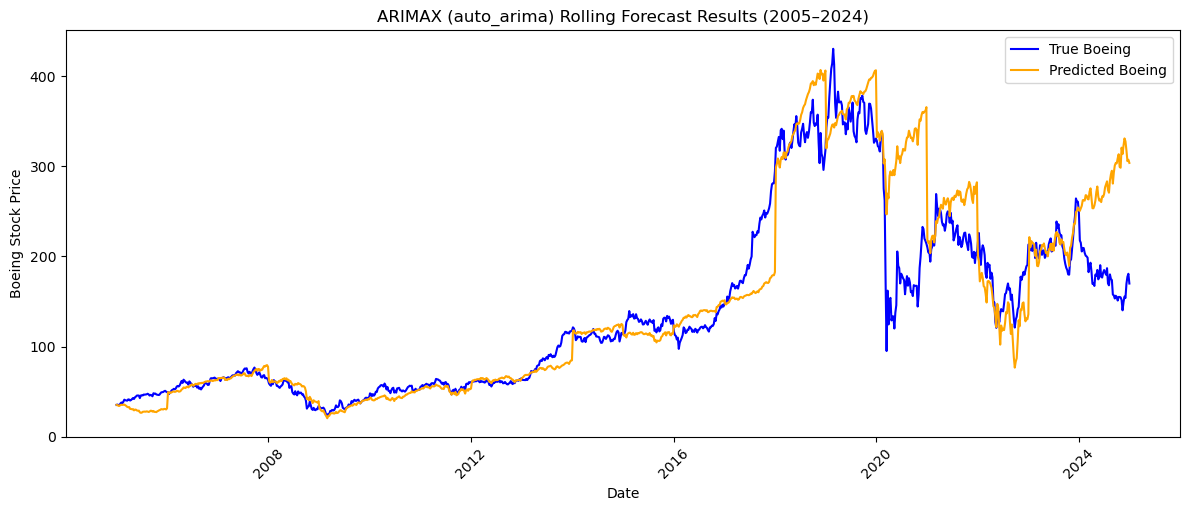

In [41]:
plt.figure(figsize=(12, 5))
plt.plot(date_all, true_all, label='True Boeing', color='blue')
plt.plot(date_all, predicted_all, label='Predicted Boeing', color='orange')
plt.title('ARIMAX (auto_arima) Rolling Forecast Results (2005–2024)')
plt.xlabel('Date')
plt.ylabel('Boeing Stock Price')
plt.legend()
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

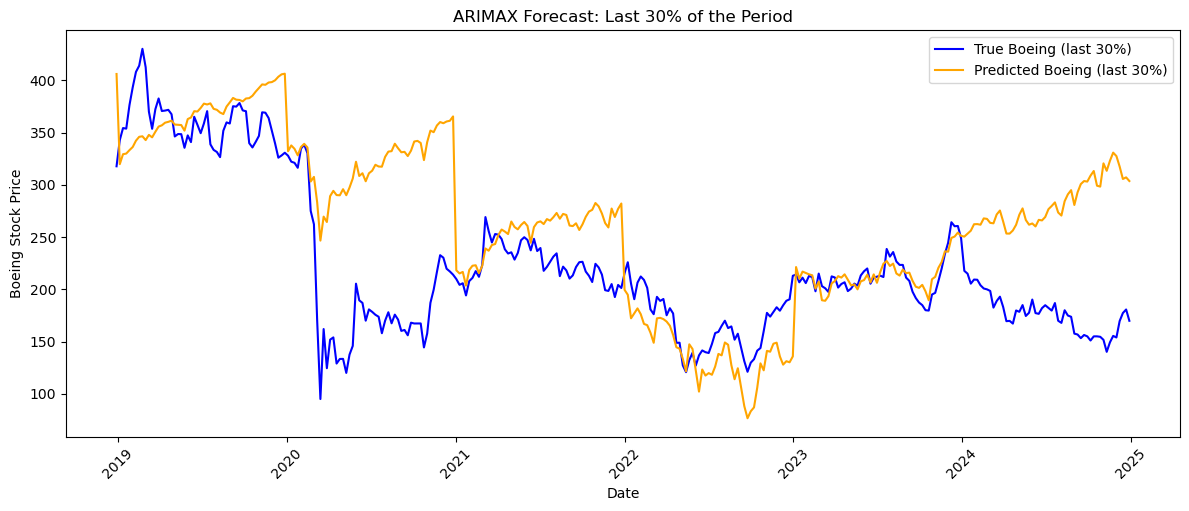

In [43]:
# 计算后 30% 的起始索引
start_index = int(len(date_all) * 0.7)

# 截取最后 30%
date_tail = date_all[start_index:]
true_tail = true_all[start_index:]
pred_tail = predicted_all[start_index:]

# 绘图
plt.figure(figsize=(12, 5))
plt.plot(date_tail, true_tail, label='True Boeing (last 30%)', color='blue')
plt.plot(date_tail, pred_tail, label='Predicted Boeing (last 30%)', color='orange')

plt.title('ARIMAX Forecast: Last 30% of the Period')
plt.xlabel('Date')
plt.ylabel('Boeing Stock Price')
plt.legend()
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()


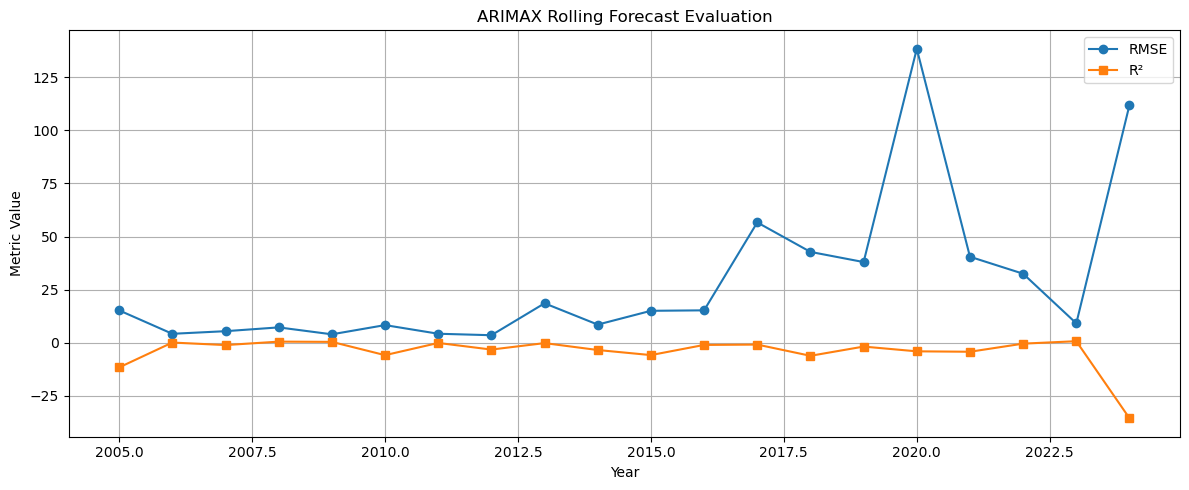

In [63]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(result_df['year'], result_df['RMSE'], marker='o', label='RMSE')
plt.plot(result_df['year'], result_df['R2'], marker='s', label='R²')
plt.title('ARIMAX Rolling Forecast Evaluation')
plt.xlabel('Year')
plt.ylabel('Metric Value')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [45]:
#滚动 VAR 模型（无外生变量）
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

results_var = []
true_all_var = []
predicted_all_var = []
date_all_var = []

for year in range(2005, 2025):
    train_data = df_new[df_new.index < f'{year}-01-01']
    test_data = df_new[(df_new.index >= f'{year}-01-01') & (df_new.index < f'{year+1}-01-01')]

    if len(test_data) == 0 or len(train_data) < 52:
        continue

    model_data = train_data[['boeing', 'DJI', 'oil']]  # ← 可替换为你要联动的内生变量
    model = VAR(model_data)
    fitted_model = model.fit(maxlags=5, ic='aic')
    lag_order = fitted_model.k_ar

    forecast_input = model_data.values[-lag_order:]
    forecast = fitted_model.forecast(y=forecast_input, steps=len(test_data))

    pred_df = pd.DataFrame(forecast, index=test_data.index, columns=model_data.columns)
    y_true = test_data['boeing']
    y_pred = pred_df['boeing']

    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)

    results_var.append({'year': year, 'MAE': mae, 'RMSE': rmse, 'R2': r2})
    true_all_var.extend(y_true)
    predicted_all_var.extend(y_pred)
    date_all_var.extend(y_true.index)


C:\Users\17376\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  self._init_dates(dates, freq)
C:\Users\17376\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\17376\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  self._init_dates(dates, freq)
C:\Users\17376\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\17376\anaconda3\Lib\site-packages\statsmodels\t

In [49]:
# 转为 DataFrame 展示
import pandas as pd
result_var_df = pd.DataFrame(results_var)
print(result_var_df)

    year         MAE        RMSE         R2
0   2005    5.994288    6.742436  -1.449454
1   2006    3.580250    4.396662   0.072838
2   2007    2.832307    3.773759   0.023419
3   2008   30.286937   36.320549  -9.821362
4   2009    4.275960    5.183609   0.077311
5   2010    7.998695    8.538657  -6.125840
6   2011    3.908532    4.517788  -0.178682
7   2012    1.452586    1.905989  -0.182337
8   2013   24.290171   29.813968  -1.904464
9   2014   15.502990   16.910094 -16.023124
10  2015   17.878240   18.902193  -9.652213
11  2016   12.390212   13.568848  -0.565642
12  2017   52.742375   65.261100  -1.422260
13  2018   84.502510  108.344108 -44.562078
14  2019   30.624718   39.357569  -1.965460
15  2020  174.967035  189.249540  -8.356692
16  2021   42.712386   53.118209  -7.940388
17  2022   56.057283   63.406629  -4.254734
18  2023   13.747373   19.631324  -0.083578
19  2024   78.105584   81.156035 -18.189154


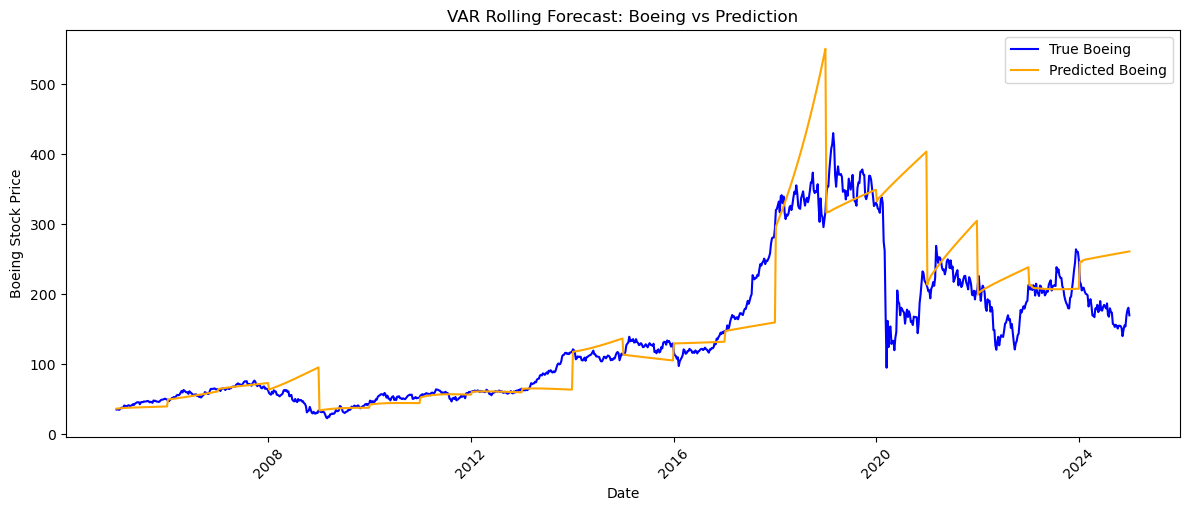

In [51]:
plt.figure(figsize=(12, 5))
plt.plot(date_all_var, true_all_var, label='True Boeing', color='blue')
plt.plot(date_all_var, predicted_all_var, label='Predicted Boeing', color='orange')
plt.xlabel('Date')
plt.ylabel('Boeing Stock Price')
plt.title('VAR Rolling Forecast: Boeing vs Prediction')
plt.legend()
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()


In [53]:
#滚动 VARX 模型（含外生变量）
from statsmodels.tsa.statespace.varmax import VARMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

results_varx = []
true_all_varx = []
predicted_all_varx = []
date_all_varx = []

for year in range(2005, 2025):  # 可调节年份
    train_data = df_new[df_new.index < f'{year}-01-01']
    test_data = df_new[(df_new.index >= f'{year}-01-01') & (df_new.index < f'{year+1}-01-01')]

    if len(test_data) == 0 or len(train_data) < 52:
        continue

    endog_train = train_data[['boeing', 'DJI']]  # 内生变量
    exog_train = train_data[['CPI', 'GDP', 'delivery']]  # 外生变量

    endog_test = test_data[['boeing', 'DJI']]
    exog_test = test_data[['CPI', 'GDP', 'delivery']]

    model = VARMAX(endog_train, exog=exog_train, order=(1, 0))  # 简化阶数，加快速度
    model_fit = model.fit(disp=False)
    forecast = model_fit.forecast(steps=len(endog_test), exog=exog_test)

    y_true = test_data['boeing']
    y_pred = forecast['boeing']

    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)

    results_varx.append({'year': year, 'MAE': mae, 'RMSE': rmse, 'R2': r2})
    true_all_varx.extend(y_true)
    predicted_all_varx.extend(y_pred)
    date_all_varx.extend(y_true.index)


C:\Users\17376\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  self._init_dates(dates, freq)
C:\Users\17376\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\17376\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\17376\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  self._init_dates(dates, freq)
C:\Users\17376\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 

In [55]:
import pandas as pd
# 转换为 DataFrame
result_varx_df = pd.DataFrame(results_varx)
# 打印误差结果
print(result_varx_df)


    year         MAE        RMSE         R2
0   2005   13.824654   15.894051 -12.611463
1   2006   12.929953   14.326278  -8.844108
2   2007    6.847017    7.994363  -3.382560
3   2008   13.688879   14.671465  -0.765729
4   2009   11.072305   12.013229  -3.955760
5   2010    3.940552    4.847616  -1.296748
6   2011    4.735474    5.902797  -1.012151
7   2012    5.157641    6.093620 -11.085128
8   2013   21.827082   26.595766  -1.311274
9   2014    5.029939    6.181425  -1.274702
10  2015   18.220816   19.195473  -9.985330
11  2016   10.094512   13.389085  -0.524433
12  2017   66.370816   80.519007  -2.687302
13  2018  100.368212  102.481178 -39.764409
14  2019   63.338424   66.466986  -7.457606
15  2020  126.168237  139.096631  -4.054589
16  2021   19.722267   23.965257  -0.819842
17  2022   43.006771   49.831745  -2.245590
18  2023   18.525492   23.569448  -0.561924
19  2024   74.721519   77.265595 -16.393481


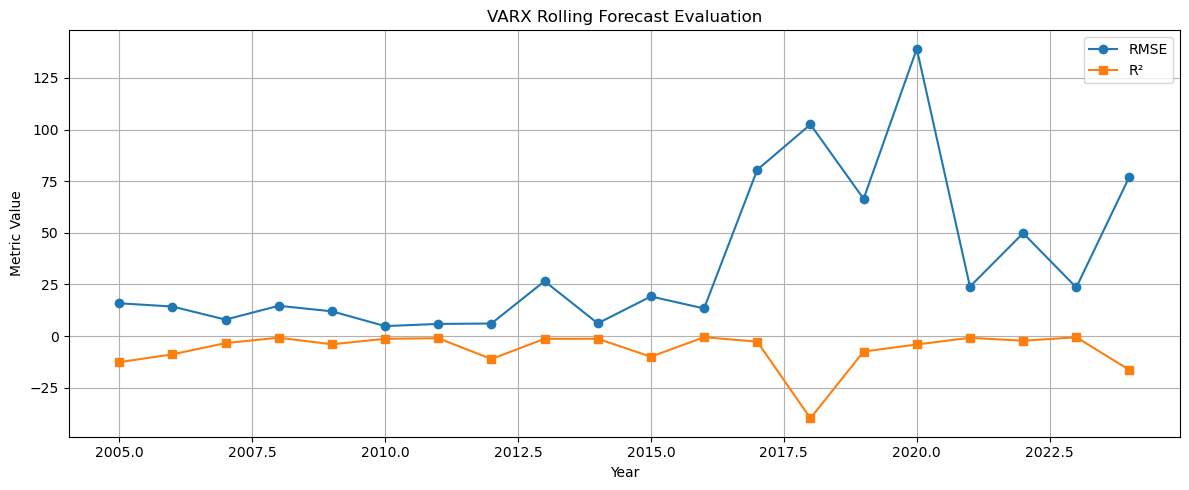

In [57]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(result_varx_df['year'], result_varx_df['RMSE'], marker='o', label='RMSE')
plt.plot(result_varx_df['year'], result_varx_df['R2'], marker='s', label='R²')
plt.title('VARX Rolling Forecast Evaluation')
plt.xlabel('Year')
plt.ylabel('Metric Value')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


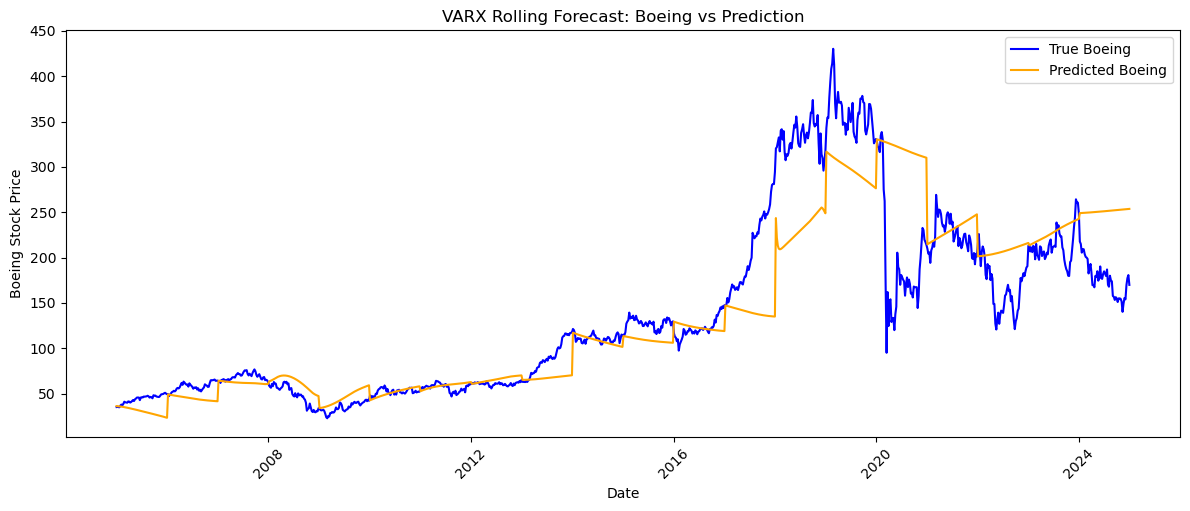

In [59]:
plt.figure(figsize=(12, 5))
plt.plot(date_all_varx, true_all_varx, label='True Boeing', color='blue')
plt.plot(date_all_varx, predicted_all_varx, label='Predicted Boeing', color='orange')
plt.title('VARX Rolling Forecast: Boeing vs Prediction')
plt.xlabel('Date')
plt.ylabel('Boeing Stock Price')
plt.legend()
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()


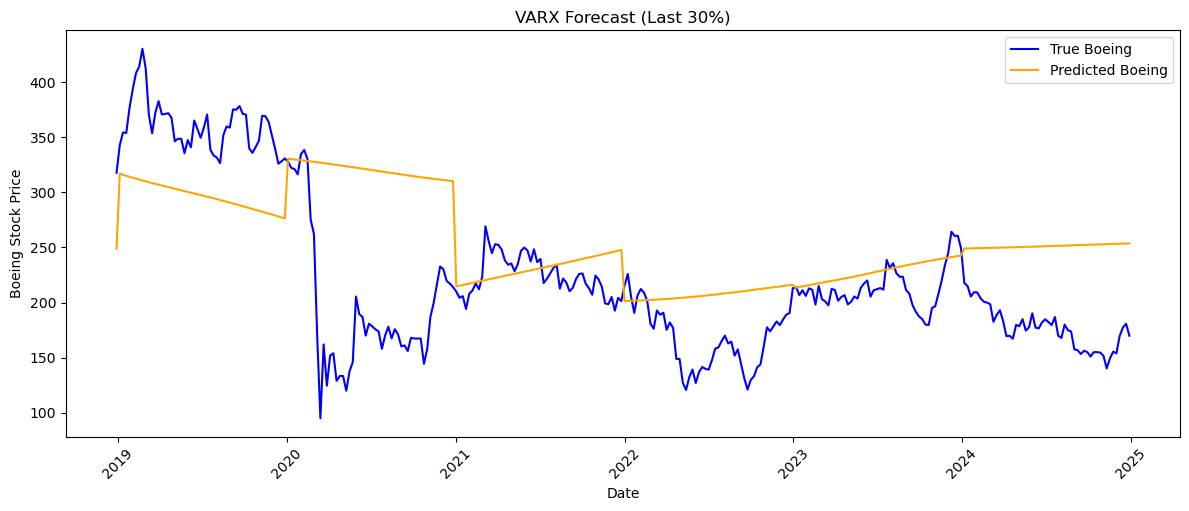

In [61]:
start_idx = int(len(date_all_varx) * 0.7)

plt.figure(figsize=(12, 5))
plt.plot(date_all_varx[start_idx:], true_all_varx[start_idx:], label='True Boeing', color='blue')
plt.plot(date_all_varx[start_idx:], predicted_all_varx[start_idx:], label='Predicted Boeing', color='orange')
plt.title('VARX Forecast (Last 30%)')
plt.xlabel('Date')
plt.ylabel('Boeing Stock Price')
plt.legend()
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()
